# Gap Missing Values

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

working dir /home/tales/dev/master/mdc_analysis


In [2]:
import pandas as pd
import math

from bokeh.models import PrintfTickFormatter
from bokeh.io import output_notebook, show

from src.dao import csv_dao, objects_dao
from src.plot.basic_plot import plot_result
from src.similarity.extreme_travelers import sequence_report
from src.utils.time_utils import human_time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
output_notebook()

Loading BokehJS ...

## Loading User Data

In [4]:
# users_srg = objects_dao.load_all_stop_region_group_object()
# users_tags = objects_dao.load_users_tags_sequence(sr_stay_time_above_h=0.5)["orignal"]

In [5]:
users_gps_dir = os.listdir("outputs/user_gps/")
users_gps = {}

for user_gps_dir in users_gps_dir:
    user = user_gps_dir.split("_")[0]
    users_gps[user] = csv_dao.load_user_gps_csv(user)

## Gaps

How many gaps above 06h ? <br> 
How many gaps above 12h ? <br> 
How many gaps above 24h ? <br>
How many gaps above 48h ? <br>
How much time the user has participated?

In [6]:
def gap_missing_values(report):
    t2 = report.iloc[1:len(report)]["local_time"].astype(float).reset_index(drop=True)
    t1 = report.iloc[0:len(report) - 1]["local_time"].astype(float).reset_index(drop=True)
    return t2 - t1

def gap_amount(gap, min_time_h):
    present_data_sum = gap[gap <= 60 * 60 * min_time_h].sum()
    missing_data_sum = gap[gap > 60 * 60 * min_time_h].sum()
    
    return {"missing_data_sum": missing_data_sum, "present_data_sum": present_data_sum}

def user_time_participation(report):
    first = report["local_time"].min()
    last = report["local_time"].max()
    
    n_days = (last - first) / (60*60*24)
    
    return {"n_days": n_days,
            "n_years": n_days / 365.25,
            "datetime_start": human_time(first, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"],
            "datetime_end": human_time(last, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"]}
    
def gaps_summary(gaps, min_time_h):
    selection = gaps[gaps > 60 * 60 * min_time_h]
    return {"n_gaps": len(selection),
            "median_sec": selection.median(),
            "min_time_gap": min_time_h}

def merge_dicts(dicts):
    final_dict = {}
    
    for d in dicts:
        
        for k in d.keys():
            final_dict[k] = d[k]

    return final_dict

def gaps_week(gaps, user_data, min_time_h):    
    gaps_df = pd.DataFrame({"gaps": gaps.tolist(), "local_time": user_data["local_time"][0:-1].tolist()})
    gaps_df["week"] = ((gaps_df["local_time"] - gaps_df["local_time"].min()) / (60*60*24*7)).apply(math.floor)
    
    return gaps_df[gaps_df["gaps"] > 60*60*min_time_h]

In [7]:
gaps_data = []

for user_id in users_gps.keys():
    user_gps = users_gps[user_id]
   
    if len(user_gps) == 0:
        continue

    gaps = gap_missing_values(user_gps)
    
    user_data = {"user_id": user_id}
    user_time = user_time_participation(user_gps)
    
    for hour in [6, 12, 18, 24, 30, 36, 42, 48]:
        user_gaps_report = gaps_summary(gaps, hour)
        gap_time_sum = gap_amount(gaps, hour)
        
        gaps_data.append(merge_dicts([user_data, user_time, user_gaps_report, gap_time_sum]))

gaps_data = pd.DataFrame(gaps_data)[["user_id", "min_time_gap", "n_gaps", "median_sec", "missing_data_sum", "present_data_sum", "datetime_end", "datetime_start", "n_years", "n_days"]]

### Counting number of gaps 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

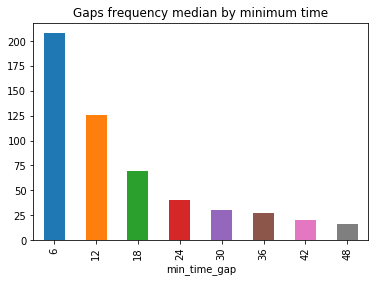

In [8]:
gaps_data.groupby("min_time_gap")["n_gaps"].median().plot.bar(title="Gaps frequency median by minimum time")

### Counting frequency of gaps per day 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

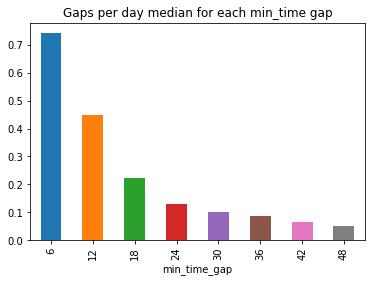

In [9]:
gaps_data["gaps_per_day"] = gaps_data["n_gaps"] / gaps_data["n_days"]
gaps_data.groupby("min_time_gap")["gaps_per_day"].median().plot.bar(title="Gaps per day median for each min_time gap")

### What is the proportion of total gaps times 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

In [10]:
gaps_data["valid_amount_h"] = gaps_data["missing_data_sum"] / (gaps_data["missing_data_sum"] + gaps_data["present_data_sum"])

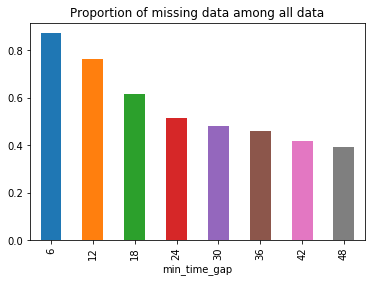

In [11]:
gaps_data.groupby("min_time_gap")["valid_amount_h"].median().plot.bar(title="Proportion of missing data among all data")

# Case Study

In [12]:
def gaps_report(users_gps, user_id, min_time_gap_h):
    user_id = str(user_id)
    print("USER:", user_id)
    print()
    user_data = users_gps[user_id]
    gaps = gap_missing_values(user_data)
    print("total days    : {0:.2f}".format(user_time_participation(user_data)["n_days"]))
    print("total hours   : {0:.2f}".format((user_data["local_time"].max() - user_data["local_time"].min()) / (60*60) ))

    print()
    amount = gap_amount(gaps, min_time_h=6)
    print("gap hours     : {0:.2f}h".format(amount["missing_data_sum"] / (60*60)))
    print("gap prop.     : {0:.2f}%".format(amount["missing_data_sum"] *100 / (amount["present_data_sum"] + amount["missing_data_sum"])))

    print()
    summary = gaps_summary(gaps, min_time_h=min_time_gap_h)
    print("n gaps {}h    : {}".format(summary["min_time_gap"], summary["n_gaps"]))
    print("gap len       : {0:.2f}h (median)".format(summary["median_sec"] / (60*60)))
    
    gaps_df = gaps_week(gaps, user_data, min_time_h=min_time_gap_h)
    gaps_week_df = gaps_df.groupby("week")["gaps"].sum()
    gaps_week_df = gaps_week_df / (60*60)

    p = plot_result(xs=gaps_week_df.index.tolist(), 
                    ys=gaps_week_df.tolist(), 
                    x_label="week", 
                    y_label="gap total hours", 
                    line_width=1, circle_size=4, alpha=0.3, 
                    title="User: {} - Gap lengths per week - considering only gaps above {}h".format(user_id, min_time_gap_h), width=900, height=300)

    p.yaxis[0].formatter = PrintfTickFormatter()

    show(p)

### user 5928

In [13]:
gaps_report(users_gps, user_id=5928, min_time_gap_h=18)

USER: 5928

total days    : 497.40
total hours   : 11937.69

gap hours     : 6901.48h
gap prop.     : 57.81%

n gaps 18h    : 103
gap len       : 22.55h (median)


### user 5924

In [14]:
gaps_report(users_gps, user_id=5924, min_time_gap_h=18)

USER: 5924

total days    : 550.00
total hours   : 13200.12

gap hours     : 12035.94h
gap prop.     : 91.18%

n gaps 18h    : 122
gap len       : 34.91h (median)


### user 6037

In [15]:
gaps_report(users_gps, user_id=6037, min_time_gap_h=18)

USER: 6037

total days    : 356.02
total hours   : 8544.44

gap hours     : 7550.65h
gap prop.     : 88.37%

n gaps 18h    : 31
gap len       : 87.44h (median)


### User 6094

In [16]:
gaps_report(users_gps, user_id=6094, min_time_gap_h=18)

USER: 6094

total days    : 267.77
total hours   : 6426.59

gap hours     : 4344.75h
gap prop.     : 67.61%

n gaps 18h    : 49
gap len       : 21.25h (median)


### User 5952

In [17]:
gaps_report(users_gps, user_id=5952, min_time_gap_h=18)

USER: 5952

total days    : 5.04
total hours   : 120.87

gap hours     : 96.84h
gap prop.     : 80.12%

n gaps 18h    : 2
gap len       : 25.27h (median)


### User 6066

In [18]:
gaps_report(users_gps, user_id=6066, min_time_gap_h=18)

USER: 6066

total days    : 443.90
total hours   : 10653.51

gap hours     : 9977.37h
gap prop.     : 93.65%

n gaps 18h    : 6
gap len       : 24.61h (median)


### User 6067

In [19]:
gaps_report(users_gps, user_id=6067, min_time_gap_h=18)

USER: 6067

total days    : 48.25
total hours   : 1157.98

gap hours     : 413.81h
gap prop.     : 35.74%

n gaps 18h    : 3
gap len       : 29.88h (median)


### User 5975

In [20]:
gaps_report(users_gps, user_id=5975, min_time_gap_h=18)

USER: 5975

total days    : 43.08
total hours   : 1034.02

gap hours     : 568.59h
gap prop.     : 54.99%

n gaps 18h    : 5
gap len       : 23.01h (median)


### User 6072

In [21]:
gaps_report(users_gps, user_id=6072, min_time_gap_h=18)

USER: 6072

total days    : 187.66
total hours   : 4503.81

gap hours     : 3040.93h
gap prop.     : 67.52%

n gaps 18h    : 46
gap len       : 22.94h (median)
